# HW 4 - Variational Inference

## Tyler Hinnendael 
## Student ID: dcc7qe

### Honor Pledge

Honor Pledge: Honor Pledge - I certify that I have given credit to references used. Any collaboration with classmates on this assignment was limited to discussion. The answers, code and analysis are my own or attributed to the proper references.

### References used

1. Gaussian Mixture Model Expectation Maximization code (3 .py files created by Dr. Basener)

2. Office hours video

3. Reference - Module 8.4 video and slides for the posterior probability formula of EM 

4. https://www.kaggle.com/billbasener/pymc3-variation-inference-neural-network

5. chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/https://arxiv.org/pdf/2010.14860.pdf - referenced for the ELBO 



# Question 1: 

(33) Use the EM implementation for Gaussian mixture models (GMM) in sklearn to segment the image Haiti Image.tif into four classes. Then answer the following questions:

In [1]:
## Set up the environment
from sklearn.mixture import GaussianMixture
from sklearn import mixture
from sklearn.cluster import KMeans

from scipy import linalg
import matplotlib as mpl

import numpy as np
np.__version__ 
'1.21.4' 
import itertools
import matplotlib.pyplot as plt
from PIL import Image
import os
print(__doc__)

/Users/tylerhinnendael/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


1.21.4


In [303]:
# read the image and convert to numpy array
im = Image.open('Haiti_Image.tif')
imArray = np.array(im)
nrows, ncols, nbands = np.shape(imArray)

### Compare between K-means and the GMM function

Segment this image using K-means using 4 classes by selecting ap-
propriate parameters in the GMM sklearn function. Compare the
classi cation results obtained with the GMM to those obtained from
K-means (KM) segmentation of the same image. Show the results
of the two approaches to segmentation as images with the separate
classes shown in di erent colors. Comment on the similarities and
di erences in the two segmentations.

In [317]:
def get_model_results(imArray, nrows, ncols, nbands, 
                      model_type = 'GMM', cov_type = 'full', n_components = 4):
    
    '''
    can take parameters for model type: GMM or KMeans
    if it is a GMM model, it can take the four different parameters for covariance_type
    '''
    
    # reshape the image array to num_observations by num_features (1,000,000 by 3)
    X = np.reshape(imArray,[nrows*ncols,nbands])

    # Create and train our Gaussian Mixture Expectation Maximization Model
    if (model_type == 'GMM'):
        model = GaussianMixture(n_components=n_components, tol=0.1,
                                covariance_type = cov_type)
    else: # model type is K-means
        model = KMeans(n_clusters = 4)
        
    model.fit(X)
    
    # predict latent values
    yhat = model.predict(X)

    # reshape the result into an image
    imSubset_hat = np.reshape(yhat,[nrows,ncols])

    return(imSubset_hat, model, X, yhat)

#### call the 'model results' function for the best GMM parameters and kmeans to compare

In [321]:
# call the model results function for kmeans
model_type = 'Kmeans'
imSubset_hat_kmeans, model_kmeans, X, yhat_kmeans = get_model_results(
    imArray, nrows, ncols, nbands, model_type = model_type)

# call the model results function for the best model for GMM
model_type = 'GMM'
imSubset_hat_gmm, model_gmm, X, yhat_gmm = get_model_results(
    imArray, nrows, ncols, nbands, model_type = model_type, 
    cov_type = 'full', n_components = 4)

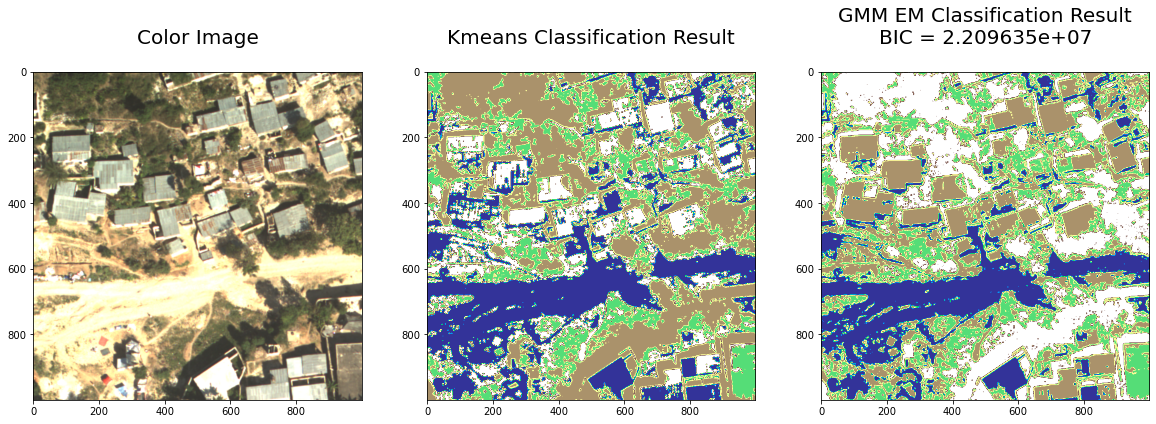

In [324]:
# plot the output, including the BIC in the title
fig, ax = plt.subplots(1, 3, figsize = (20, 15))

ax[0].imshow(imArray)
ax[0].set_title('Color Image\n', size = 20)

ax[1].imshow(imSubset_hat_kmeans, cmap = 'terrain')
ax[1].set_title('Kmeans Classification Result\n', size = 20)

ax[2].imshow(imSubset_hat_gmm, cmap = 'terrain')
subtitle = 'BIC = '+"{:e}".format(model_gmm.bic(X))
ax[2].set_title('GMM EM Classification Result\n' + subtitle + '\n', size = 20);

**ANALYSIS:**

The GMM model was created using the 'full' covariance type and 4 components. The output above shows the segmentation of the 4 classes from K-means clustering in the middle, and GMM on the right. 

While the colors for each class do not match up for each class, we can compare the two graphics. Here is what each color conveys in each graphic:

Kmeans: blue = lighter dirt/sand, brown = vegetation, white = rooftops, green = darker dirt/sand
GMM: blue = lighter dirt/sand, white = vegetation, brown = rooftops, green = darker dirt/sand

Both models clustered the three classes for the dirt/sand, road, and vegetation similarly. These are pretty well grouped compared to what is actually in the image. The GMM model more precisely identified entire rooftops than the Kmeans model. Both appear to have missed the rooftop in the bottom right. The Kmeans model provides a bit too much detail in the pixels of the rooftops, which makes those portions of the image appear to be multiple objects. Because of this, the GMM does a better job of clustering the image. 



### Equation for Posterior Prediction

Write the equation for the posterior prediction of the probability of
the class label for each data point in the image.

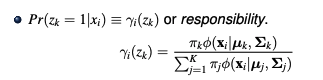

**NOTE** 

The formula above outputs the probability that a data point is a member of a component or cluster.

Reference - Module 8.4 video and slides

### Show separate images for each class

Show four separate images, one for each class, that color code the
probabilities of a class label for each data point in the image. Com-
ment on the insights provided by this probabilistic view of the seg-
mentation. Very brie
y describe example of how this probabilistic
perspective might be used by governmental or non-pro t agencies
concerned with improving the environment or the living conditions
in Haiti.

In [307]:
# calculates probabilities of each class for each sample (image pixel)
def get_probabilities(gmm_probs_all_classes, class_ind):
    
    # holds the probabilities for this class only
    probs_class = []

    # loops through each pixel in probs for all classes and pulls out 
    # probs for just this class
    for ind in range(len(gmm_probs_all_classes)):
        probs_class.append(gmm_probs_all_classes[ind][class_ind])

    im_probs_class = np.reshape(probs_class, [nrows, ncols]) # reshape for the image
    
    return(im_probs_class, np.array(probs_class))
    
# reshape the result into an image
#imSubset_hat = np.reshape(yhat,[nrows,ncols])
#plt.imshow(im_probs_class_0, cmap = 'PuBu')

In [308]:
# probs_all_classes holds 1,000,000 x 4 - a probability for pixel for each class
gmm_probs_all_classes = model_gmm.predict_proba(X)

# call the function
# im_probs_class holds the re-shaped probabilities for each class
# probs_class holds an array of len(1,000,000) with the probabilities
im_probs_class_0, probs_class_0 = get_probabilities(gmm_probs_all_classes, 0)
im_probs_class_1, probs_class_1 = get_probabilities(gmm_probs_all_classes, 1)
im_probs_class_2, probs_class_2 = get_probabilities(gmm_probs_all_classes, 2)
im_probs_class_3, probs_class_3 = get_probabilities(gmm_probs_all_classes, 3)

# look at the mean value for the probabilities for each class
print("Class 0: ", probs_class_0.mean())
print("Class 1: ", probs_class_1.mean())
print("Class 2: ", probs_class_2.mean())
print("Class 3: ", probs_class_3.mean())

Class 0:  0.27988016706636576
Class 1:  0.19831133952696778
Class 2:  0.22586469518073102
Class 3:  0.2959437982259352


**Code to create a custom colormap -- didn't work too well, pre-made color maps are better**

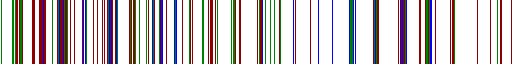

In [294]:
from matplotlib.colors import ListedColormap

# get the pixel_colors for each class
def get_pixel_colors(im_probs_class):
    
    pixel_colors = []
    
    # assign based on the probability in im_probs for that class
    for ind1 in range(1000):
        for ind2 in range(1000):
            if (im_probs_class[ind1][ind2] > 0.98): # 0.98
                pixel_colors.append('darkred')
            elif (im_probs_class[ind1][ind2] > 0.9): # 0.9
                pixel_colors.append('green') # firebrick
            elif (im_probs_class[ind1][ind2] > 0.5): # 0.5
                pixel_colors.append('blue') # tomato
            #elif (im_probs_class[ind1][ind2] > 0.01):
            #    pixel_colors.append('white')   
            else: 
                pixel_colors.append('white')

    cmap_class = ListedColormap(pixel_colors)
    return(cmap_class)

cmap_class_0 = get_pixel_colors(im_probs_class_0)
cmap_class_1 = get_pixel_colors(im_probs_class_1)
cmap_class_2 = get_pixel_colors(im_probs_class_2)
cmap_class_3 = get_pixel_colors(im_probs_class_3)

cmap_class_0

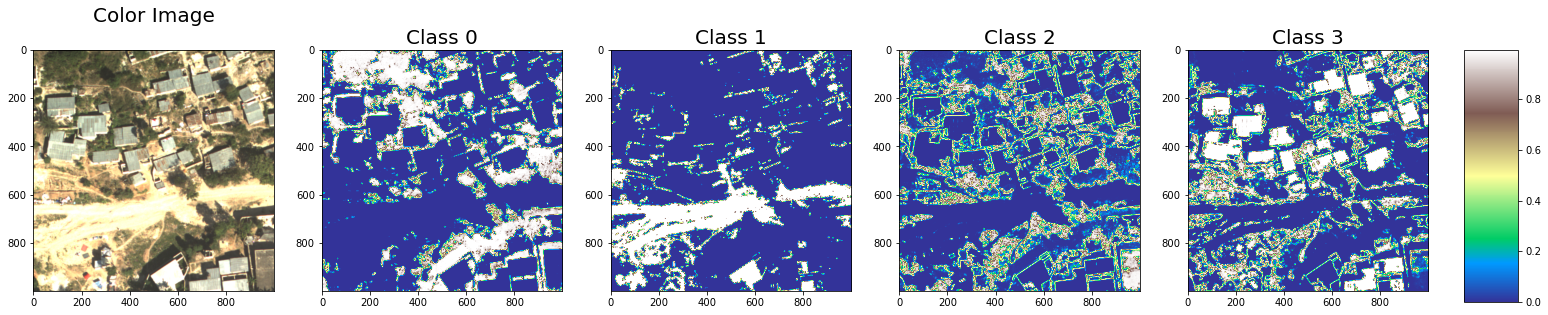

In [311]:
# plot the output, including the BIC in the title
fig, ax = plt.subplots(1, 5, figsize = (25, 10))

ax[0].imshow(imArray)
ax[0].set_title('Color Image\n', size = 20)

# class 0
im = ax[1].imshow(im_probs_class_0, cmap = 'terrain')
ax[1].set_title('Class 0', size = 20)

# class 1
ax[2].imshow(im_probs_class_1, cmap = 'terrain') # afmhot
ax[2].set_title('Class 1', size = 20)

# class 2
ax[3].imshow(im_probs_class_2, cmap = 'terrain')
ax[3].set_title('Class 2', size = 20)

# class 3
ax[4].imshow(im_probs_class_3, cmap = 'terrain')
ax[4].set_title('Class 3', size = 20);

c = plt.colorbar(im, cax = fig.add_axes([0.92, 0.32, 0.03, 0.35]))

plt.show()

**ANALYSIS:**

The images above overlay colors for the probability that each pixel in the image belongs to one of the 4 classes, as a result of the GMM model. The colorbar on the right shows which color in the image corresponds to higher probabilities of belonging to that class. White indicates the highest probability of belonging to that class, while blue is the lowest probability for those pixels. The probabilities are derived from running model.predict_proba(X) on the GMM model results. 

Class 0 appears to be the vegetation, class 1 appears to be lighter sand/dirt such as the road, class 2 appears to be dirt/dark brown objects, and class 3 indicates rooftops. Analyzing the images expands on the clustering by not only providing the cluster which a pixel (object) belongs to, but also knowledge of the probability that it belongs to that cluster. For example, if Class 3 were to include rooftops that were brown, but still were clustered with class 3, we could begin to assess that locations where white pixels are have a greater probability of being rooftops than the brown ones.

Using these probabilities and overlaying them on the image is extremely useful for prioritizing operations by government and non-profit organizations. For example, if our use case is to identify blue tarps in the Haiti earthquake, then being able to provide a probability that an object is a blue tarp can give a level of confidence in our model and each individual image. This can allow rescue crews to prioritize. If one of the classes were to appear to identify blue tarps, probably in a model with 5 clusters, then rescue team leaders could first direct operations towards objects that have 90% probability or greater. If resources and time allows, then later on they might direct operations toward objects with 60% probability or greater. The probability threshold would depend on the resources of rescue teams.

Another application, regarding improving the living condition or environment in the country, could be to identify areas that are over-developed or lack vegetation, an indication of environmental damage. Areas that have large patches of dead vegetation (class 1 or 2) could be identified and then targeted for planting new trees. Areas that appear to be be over-developed could be identified by large numbers of rooftops (class 3) and then targeted to limit new construction. The overlaid probabilities would be used the same way for these applications as for rescue operations, in that the objects with higher probabilities will be targeted first.


# Question 2:

(50) Modify the Neural Network Variational Inference notebook (https://www.kaggle.com/billbasener/pymc3-variation-inference-neural-network) by adding a different nonlinear 2-dimensional
data and training the network and analyzing the results provided for the
make moons data. You can use data provided in sklearn.datasets or any
2D data you can  nd or create. You can modify the network (number of
neurons or layers) as needed.

**Note - I imported the graphics from running this code in kaggle and then added analysis in this notebook so that I could run pymc3.**|

In [ ]:
%matplotlib inline
import theano
import pymc3 as pm
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from warnings import filterwarnings
filterwarnings('ignore')
sns.set_style('white')
from sklearn import datasets
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_circles

In [ ]:
X, Y = make_blobs(centers = 2, random_state=0, n_samples=1000)
X = scale(X)
X = X.astype(float)
Y = Y.astype(float)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.5)

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(X[Y==0, 0], X[Y==0, 1], label='Class 0')
ax.scatter(X[Y==1, 0], X[Y==1, 1], color='r', label='Class 1')
sns.despine(); ax.legend()
ax.set(xlabel='X', ylabel='Y', title='Toy binary classification data set');

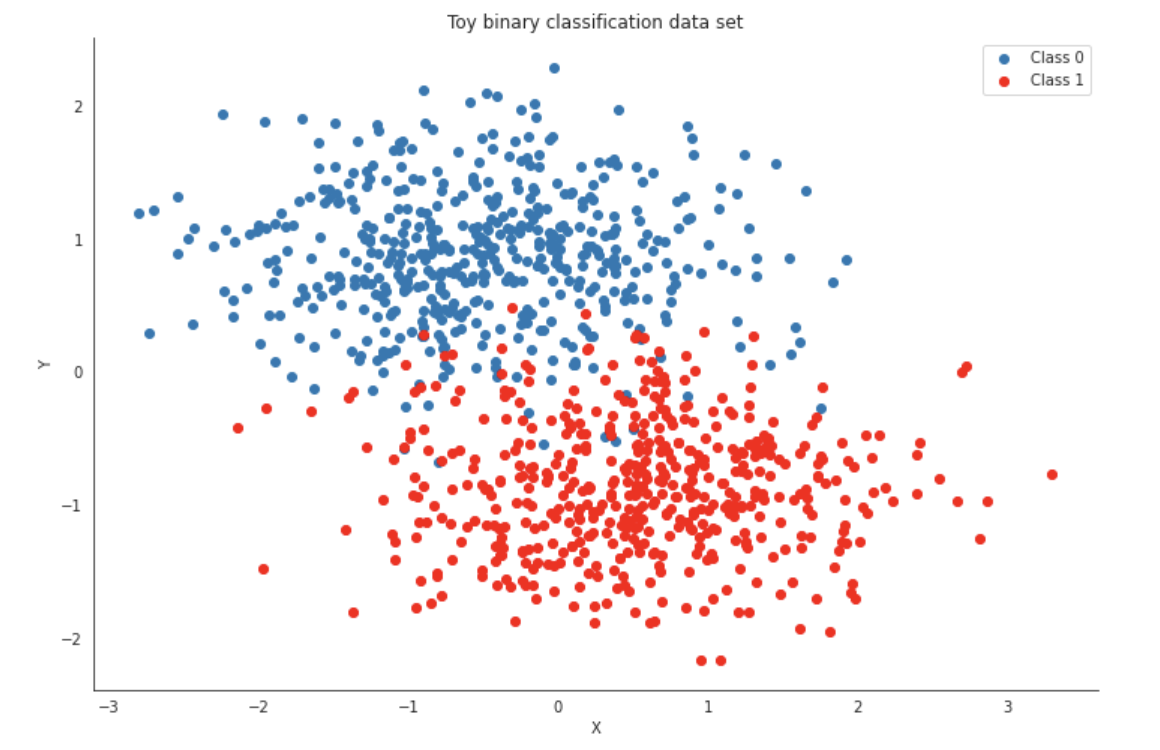

In [ ]:
# just to see the dimensions o four data
print(X_train.shape)
print(Y_train.shape)

(500, 2)

(500,)

#### Model Specification

In [ ]:
def construct_nn(ann_input, ann_output):
    n_hidden = 5 # Number of neurons in each hidden layer
    
    # Initialize random weights between each layer
    init_1 = np.random.randn(X.shape[1], n_hidden).astype(float)
    init_2 = np.random.randn(n_hidden, n_hidden).astype(float)
    init_out = np.random.randn(n_hidden).astype(float)
        
    with pm.Model() as neural_network:
        # Weights from input to hidden layer
        weights_in_1 = pm.Normal('w_in_1', 0, sd=1, 
                                 shape=(X.shape[1], n_hidden), 
                                 testval=init_1)
        
        # Weights from 1st to 2nd layer
        weights_1_2 = pm.Normal('w_1_2', 0, sd=1, 
                                shape=(n_hidden, n_hidden), 
                                testval=init_2)
        
        # Weights from hidden layer to output
        weights_2_out = pm.Normal('w_2_out', 0, sd=1, 
                                  shape=(n_hidden,), 
                                  testval=init_out)
        
        # Build neural-network using tanh activation function
        act_1 = pm.math.tanh(pm.math.dot(ann_input, 
                                         weights_in_1))
        act_2 = pm.math.tanh(pm.math.dot(act_1, 
                                         weights_1_2))
        act_out = pm.math.sigmoid(pm.math.dot(act_2, 
                                              weights_2_out))
        
        # Binary classification -> Bernoulli likelihood
        out = pm.Bernoulli('out', 
                           act_out,
                           observed=ann_output,
                           total_size=Y_train.shape[0] # IMPORTANT for minibatches
                          )
    return neural_network

# Trick: Turn inputs and outputs into shared variables. 
# It's still the same thing, but we can later change the values of the shared variable 
# (to switch in the test-data later) and pymc3 will just use the new data. 
# Kind-of like a pointer we can redirect.
# For more info, see: http://deeplearning.net/software/theano/library/compile/shared.html
ann_input = theano.shared(X_train)
ann_output = theano.shared(Y_train)
neural_network = construct_nn(ann_input, ann_output)

In [ ]:
from pymc3.theanof import set_tt_rng, MRG_RandomStreams
set_tt_rng(MRG_RandomStreams(42))

In [ ]:
%%time

with neural_network:
    inference = pm.ADVI()
    approx = pm.fit(n=50000, method=inference)

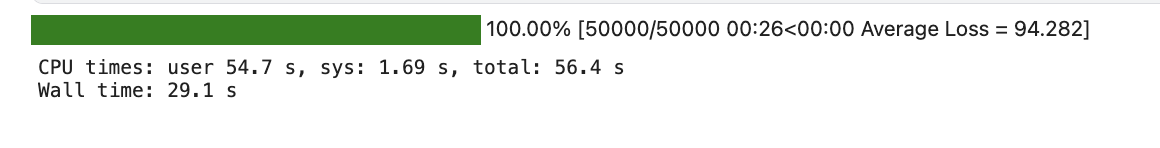
        

In [ ]:
trace = approx.sample(draws=5000)

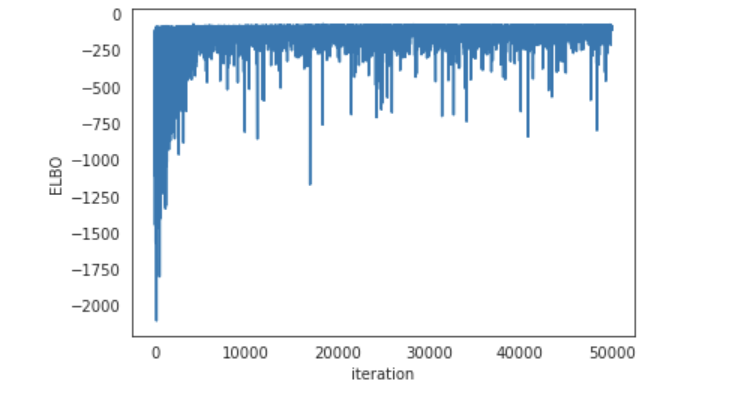

In [ ]:
# Replace arrays our NN references with the test data
ann_input.set_value(X_test)
ann_output.set_value(Y_test)

with neural_network:
    ppc = pm.sample_posterior_predictive(trace, samples=500, progressbar=False)

# Use probability of > 0.5 to assume prediction of class 1
pred = ppc['out'].mean(axis=0) > 0.5

#### Look at our predictions

In [ ]:
fig, ax = plt.subplots()
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
sns.despine()
ax.set(title='Predicted labels in testing set', xlabel='X', ylabel='Y');

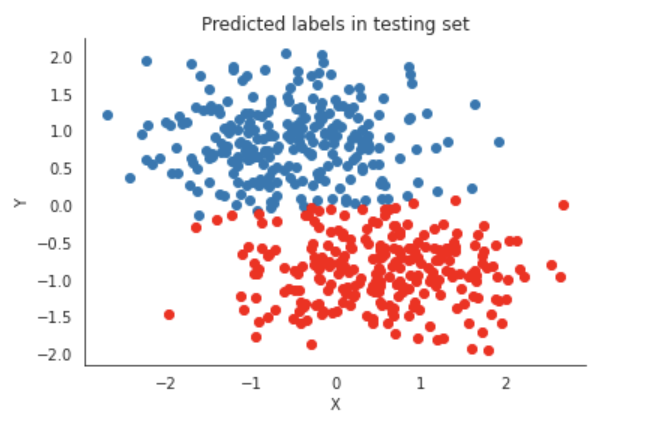

In [ ]:
print('Accuracy = {}%'.format((Y_test == pred).mean() * 100))

Accuracy = 95.8%

#### Look at what the classifier has learned

In [ ]:
grid = pm.floatX(np.mgrid[-3:3:100j,-3:3:100j])
grid_2d = grid.reshape(2, -1).T
dummy_out = np.ones(grid.shape[1], dtype=np.int8)

In [ ]:
ann_input.set_value(grid_2d)
ann_output.set_value(dummy_out)

with neural_network:
    ppc = pm.sample_posterior_predictive(trace, samples=500, progressbar=False)

### Discuss Probability

Include and discuss the probability results for your data.

In [ ]:
# Probability Surface
cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
fig, ax = plt.subplots(figsize=(14, 8))
contour = ax.contourf(grid[0], grid[1], ppc['out'].mean(axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
cbar.ax.set_ylabel('Posterior predictive mean probability of class label = 0');

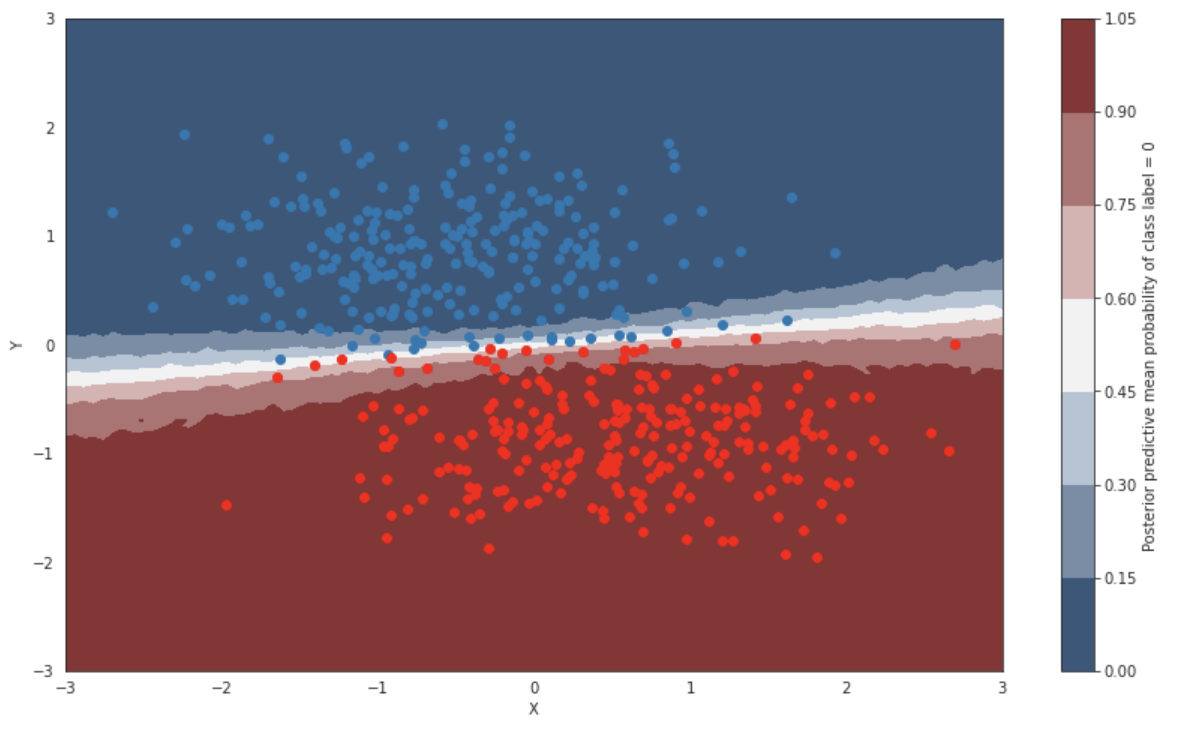

**ANALYSIS:**

The graphic above conveys the probability that a given point from a blob belongs to one of the classes. This is very powerful because non-Bayesian classification models simply provide a class label, without providing the probability that this class label is accurate. The points that fall within the dark red and dark blue backgrounds have a probability greater than 0.9. As we move closer to the white in the middle, the probability of a point belonging to a class decreases closer to 0.5, and these margins become thinner (the area of each of these sections decreases). If we wanted examine specific data points, we could use this information by looking at the probability for that data point and its class. Looking at the bigger picture, we can see that these two blobs are pretty evenly separated by a linear boundary.



### Discuss Uncertainty

Include and discuss the uncertainty results derived from the standard
deviation in the posterior predictive.

In [ ]:
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig, ax = plt.subplots(figsize=(14, 8))
contour = ax.contourf(grid[0], grid[1], ppc['out'].std(axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
cbar.ax.set_ylabel('Uncertainty (posterior predictive standard deviation)');

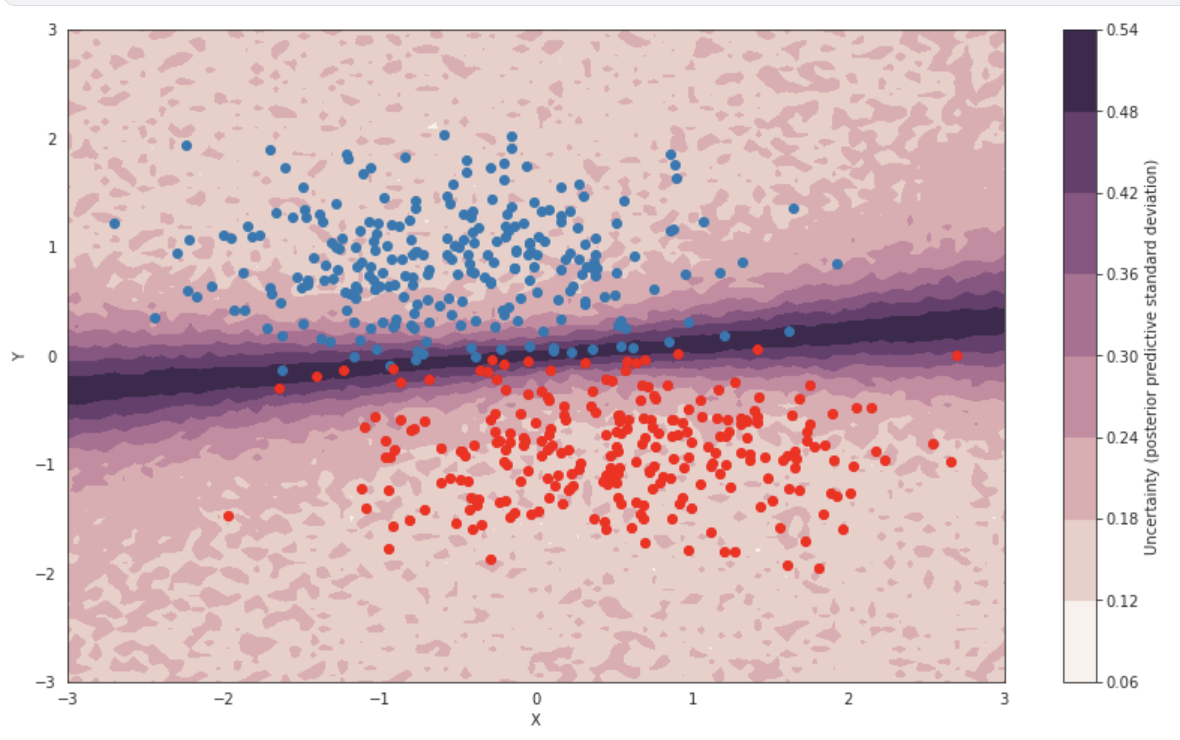

**ANALYSIS:**

The plot above provides a confidence level with our predictions. Again, this is not provided through non-Bayesian classification methods which provide overall model accuracy, precision and recall, but not uncertainty for each data point. The lighter colors on the spectrum, the white and light pink, provide higher certainty that each point is classified correctly. Closer to the boundary separating the classes, our uncertainty decreases to just above 50%. For those points, we might decide that the model is better than 50/50 chance, but with low certainty. Similarly to how we would use the probability values for individual data points, we can access the uncertainty for individual data points that might be of interest and therefore give a confidence level in our assessment. Looking at overall trends, we are over 75% confident in the class assignment for most of the data points (~90%).


In [ ]:
import numpy as np
np.max( ppc['out'].std(axis=0))

0.5

#### Mini-batch ADVI

In [ ]:
minibatch_x = pm.Minibatch(X_train, batch_size=32)
minibatch_y = pm.Minibatch(Y_train, batch_size=32)

neural_network_minibatch = construct_nn(minibatch_x, minibatch_y)
with neural_network_minibatch:
    inference = pm.ADVI()
    approx = pm.fit(40000, method=inference)

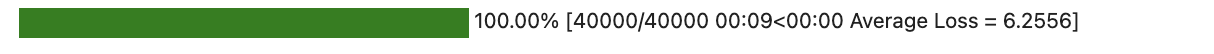

### ELBOW plot

include and discuss the plot of the ELBOW, and what that tells
about convergence to maximizing the likelihood.

In [ ]:
plt.plot(-inference.hist)
plt.ylabel('ELBO')
plt.xlabel('iteration');

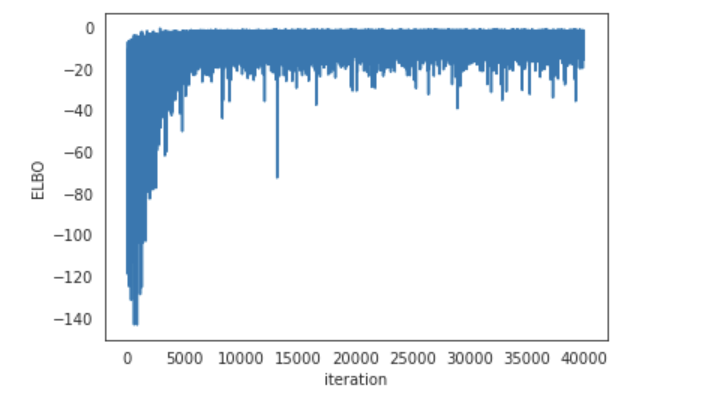

**ANALYSIS:**

The ELBO is the lower bound for the variational inference. We want to maximize the value to maximize the likelihood. The ELBO in this plot increases and stays around -20 after about 8,000 iterations. This shows that our lower bound converges over the iterations and stays around the same value through 40,000 iterations. 

Reference #5 above


### Trace Plot

Include and discuss the traceplot, focusing on what this tells you
about your network.

In [ ]:
trace_VI = approx.sample(draws=10000)
pm.traceplot(trace_VI);

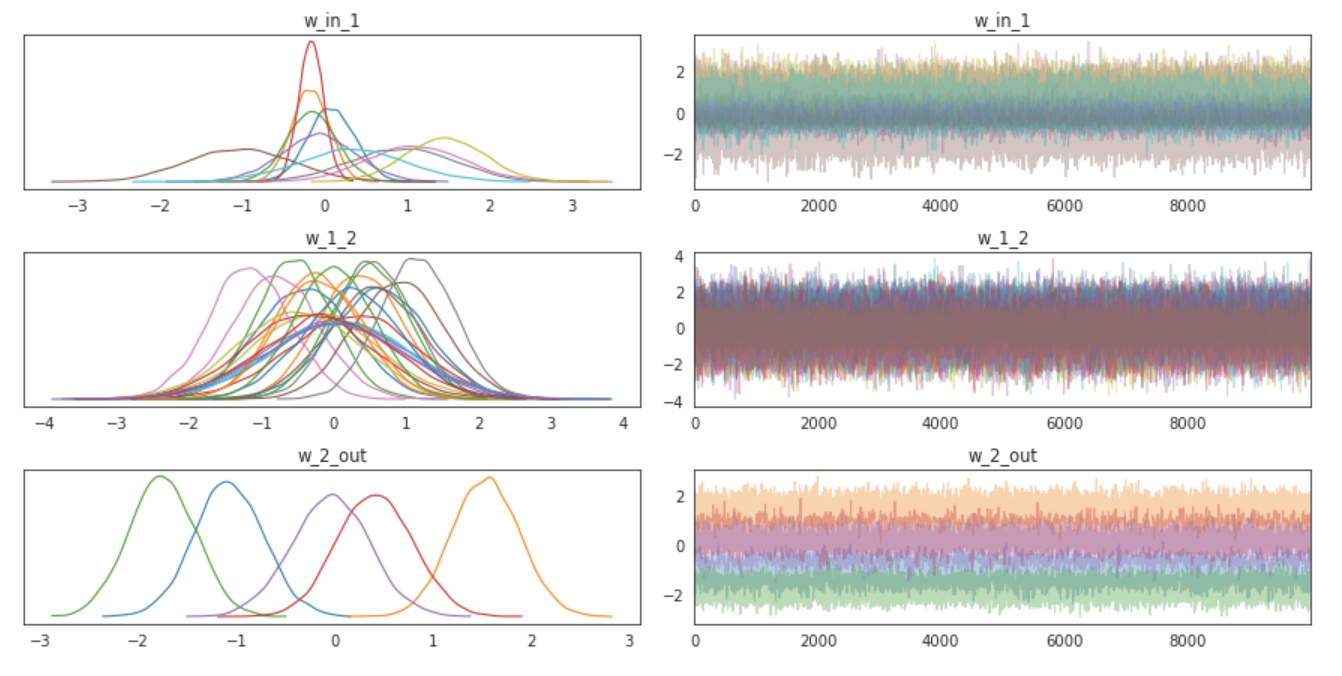

**ANALYSIS:**

The trace plot and plots of the distributions above shows the uncertainty of each of our weights. We can see that with w_in_1, there is large variation in the distributions of the weights and a lot of overlap in the traces, with some distributions being very wide (more uncertain) and others slimmer. In w_2_out, the uncertainty is more consistent across all weights, with each looking much closer to a normal distribution and having different means. This should make us more confident in the weights from w_2_out. The traces have less overlap in w_2_out.